In [262]:
import sys
sys.path.append("../")
from database import models as dm
from sqlalchemy import select, create_engine
from sqlalchemy.orm import Session
from database.env import DATABASE_URI
import matplotlib.pyplot as plt
import numpy as np

engine = create_engine(DATABASE_URI)

import importlib
importlib.reload(dm)

<module 'database.models' from '/home/hayden/repos/module_pcb_thermal_mockup/analysis/../database/models.py'>

In [ ]:
def get_sensor_data(session, run:int, module: str, sensor: str):
    module = session.execute(select(dm.Module).where(dm.Module.name == module)).scalar()
    query = select(dm.Data).where(
        dm.Data.run_id==run, dm.Data.sensor==sensor, dm.Data.module == module
    )
    return session.execute(query.order_by(dm.Data.id)).scalars().all()

def elapsed_time(time: list):
    t0 = time[0]
    return [(t - t0).total_seconds() / 60 for t in time]

def sensor_plot(data:list[dm.Data], cut_in=None, cut_out=None, **kwargs):
    if cut_in is not None and isinstance(cut_in, int):
        data = data[cut_in:]
    if cut_out is not None and isinstance(cut_out, int):
        data = data[:-cut_out]
    y_data = [d.celcius for d in data]
    ts = elapsed_time([t.timestamp for t in data])
    plt.plot(ts, y_data, **kwargs)

2024-12-10 11:39:16.503602


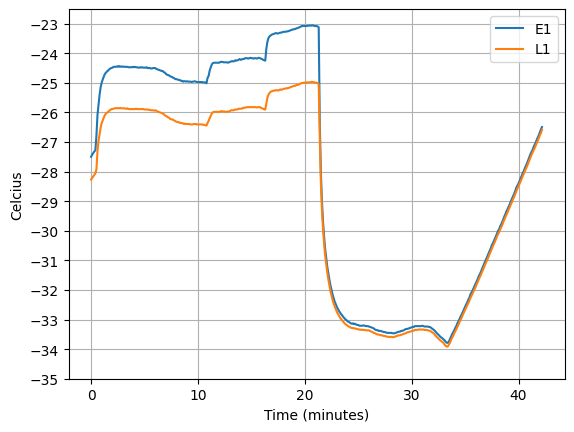

In [37]:

module = "TM1"
run = 36
etroc = "E1"
lgad = "L1"
with Session(engine) as session:
    E_data = get_sensor_data(session, run, module, etroc)
    L_data = get_sensor_data(session, run, module, lgad)
    sensor_plot(E_data, label=etroc)
    sensor_plot(L_data, label=lgad)
    plt.yticks(range(-35, -22, 1))
    #plt.xticks(range(0,43,1))
    # plt.clf()
    print(E_data[0].timestamp)
    # dT = [e.celcius - l.celcius for e, l in zip(E_data, L_data)]
    # plt.plot(elapsed_time([t.timestamp for t in E_data]), dT, label=f"{etroc}-{lgad}")
    # plt.yticks(np.arange(0, 2.5+0.25, 0.25))

    plt.legend()
    plt.grid()
    plt.xlabel("Time (minutes)")
    plt.ylabel("Celcius")

Starting Time: 2024-12-10 11:50:34.500961
AVERAGE TIME
-24.23950507702326


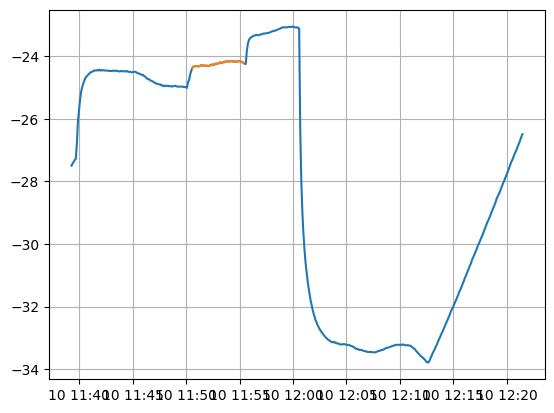

In [274]:
def get_power_levels(session, run:int, module:str, sensor:str, flat_threshold: float = 0.05) -> dict[list]:
    data = np.array(get_sensor_data(session, run, module, sensor))

    E_indices = np.array(range(len(data)))

    cdiff = np.diff([d.celcius for d in data], append=1)
    flat_regions = np.absolute(cdiff) < flat_threshold

    flat_indices = E_indices[flat_regions]

    flat_groups = []
    start_idx = 0
    for i, flat_idx in enumerate(flat_indices):
        if i == len(flat_indices)-1 or abs(flat_idx - flat_indices[i+1]) > 1:
            flat_group = flat_indices[start_idx:i+1]
            # Now get rid of the last grouped set
            start_idx = i + 1
            if len(flat_group) > 10:
                flat_groups.append(data[flat_group])

    return {i: flat_group for i, flat_group in enumerate(flat_groups)}

# Check Power levels
with Session(engine) as session:
    run = 36
    module = "TM1"
    sensor = "E1"
    level = 1
    left_offset, right_offset = 0, -1
    data = np.array(get_sensor_data(session, run, module, sensor))
    power_levels = get_power_levels(session, run, module, sensor, flat_threshold=0.05)
    level_data = power_levels[level]

    # add time offset of 1 min
    plt.plot([t.timestamp for t in data], [d.celcius for d in data])

    times = [t.timestamp for t in level_data]
    celcius = [d.celcius for d in level_data]

    plt.plot(times[left_offset:right_offset], celcius[left_offset:right_offset])
    print(f"Starting Time: {times[0]}")
    print(f"AVERAGE TIME")
    print(np.mean(celcius))
    plt.grid()

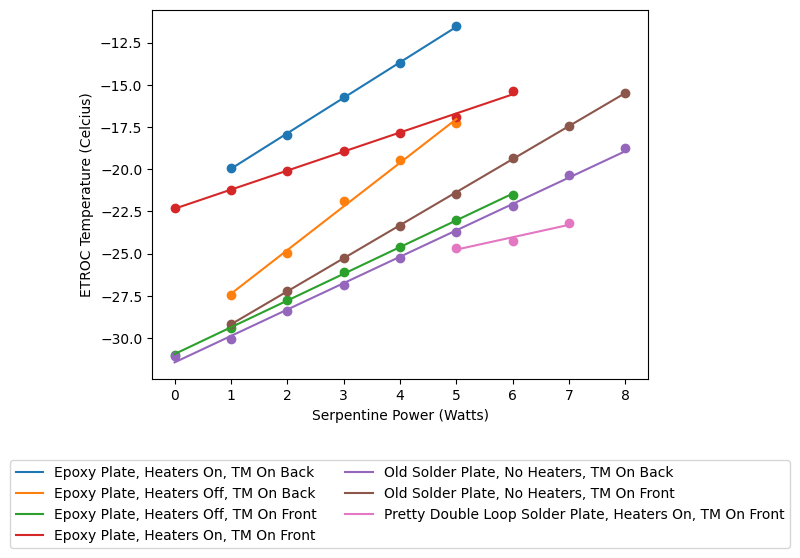

In [ ]:
# Power vs Temperature

# need the selected runs
# - epoxy plate = 8 is on 7 is off or documented 3 on and 4 off
# - solder bad plate = 13 is off only and there is 12
# - solder good plate = 36

# check the T vs Power for plates with and without heater (epoxy so you can know)

# 2024-08-15 04:30:18.625439
epoxy_run_3 = { # HEATERS = ON
    "power": [1,2,3,4,5],
    "celcius": [-19.93, -17.95,-15.74,-13.70,-11.54]
}

# 2024-08-16 09:32:21
epoxy_run_4 = { # HEATERS = OFF
    "power"  : [1,2,3,4,5],
    "celcius": [-27.45,-24.99,-21.87, -19.48,-17.26]
}

# 2024-08-20 08:22:12
epoxy_run_7 = { # HEATERS = OFF
    "power"  : [0,1,2,3,4,5,6],
    "celcius": [-31.005, -29.4203, -27.7661, -26.074, -24.598, -23.0359, -21.523]
}

# 2024-08-20 09:52:49.844597
epoxy_run_8 = { # HEATERS = ON
    "power"  : [0,1,2,3,4,5,6],
    "celcius": [-22.2757, -21.220, -20.129, -18.94972, -17.8533, -16.88, -15.386]
}

# 2024-08-22 04:09:11
bad_solder_run_12 = { # HEATERS = OFF
    "power": [0, 1, 2, 3, 4, 5, 6, 7, 8], #THIS IS A GUESS!!!!!!
    "celcius": [-31.052, -30.0778, -28.42300, -26.8661, -25.2635, -23.725, -22.1825, -20.3584, -18.768]
}

# 2024-08-23 05:06:26
bad_solder_run_13 = { # HEATERS = OFF
    "power": [1, 2, 3, 4, 5, 6, 7, 8], #THIS IS A GUESS!!!!!!
    "celcius": [-29.175,-27.247, -25.248,-23.344, -21.474, -19.343, -17.429, -15.471]
}

good_solder_run_36 = { # HEATERS = ON
    "power": [5, 6, 7],
    "celcius": [-24.664, -24.239, -23.196]
}

def plot_weird_power(power_run_data:dict[list], **kwargs) -> None:
    plt.scatter(power_run_data["power"], power_run_data["celcius"])

    # do linear fit
    x = np.array(power_run_data["power"])
    y = np.array(power_run_data["celcius"])
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, **kwargs)

# plot power vs temp
plot_weird_power(epoxy_run_3, label="Epoxy Plate, Heaters On, TM On Back")
plot_weird_power(epoxy_run_4, label="Epoxy Plate, Heaters Off, TM On Back")

plot_weird_power(epoxy_run_7, label="Epoxy Plate, Heaters Off, TM On Front")
plot_weird_power(epoxy_run_8, label="Epoxy Plate, Heaters On, TM On Front")

plot_weird_power(bad_solder_run_12, label="Old Solder Plate, No Heaters, TM On Back")
plot_weird_power(bad_solder_run_13, label="Old Solder Plate, No Heaters, TM On Front")

plot_weird_power(good_solder_run_36, label="Pretty Double Loop Solder Plate, Heaters On, TM On Front")

plt.ylabel("ETROC Temperature (Celcius)")
plt.xlabel("Serpentine Power (Watts)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

In [ ]:
import json
with Session(engine) as session:
    run_id = 36
    run_power_info = good_solder_run_36
    run = session.execute(select(dm.Run).where(dm.Run.id==run_id)).scalar_one_or_none()

    run_note = dm.RunNote(
        note = f"Power and Temperature for ETROC1: {json.dumps(run_power_info, indent=4)}",
        run=run
    )

    print(run_note.note)

    # session.add(run_note)
    # session.commit()

Power and Temperature for ETROC1: {
    "power": [
        5,
        6,
        7
    ],
    "celcius": [
        -24.664,
        -24.239,
        -23.196
    ]
}


# Run 3 (Epoxy Plate, Heaters On)
<img src="https://api.nebraskadetectorlab.com/resource/SGPJE6SYIAAIPYZ22QWN3G2TMDIJBQ33+inline?tenant=bu">


# Run 4 (Epoxy Plate, Heaters Off)
<img src="https://api.nebraskadetectorlab.com/resource/CUGVWNIDB7WNGZQGAUNUIB5XXKWXXRGU+inline?tenant=bu">

In [ ]:
# auto power level maker ehh dont use it...

# make power levels
runs = [3,4,7,8,12,13]
sensor = 'E4'
module = "TM0"
run_powers = {}
with Session(engine) as session:
    for run in runs:
        power_levels = get_power_levels(session, run, module, sensor)
        for level in power_levels:
            # start, stop and average
            power_levels[level] = {
                "start": str(power_levels[level][0].timestamp), 
                "stop": str(power_levels[level][-1].timestamp), 
                "average": np.mean([d.celcius for d in power_levels[level]])
            }

            run_powers[run] = power_levels

import json
print(json.dumps(run_powers, sort_keys=True, indent=4))